In [1]:
import theano

In [2]:
import theano.tensor as T

In [3]:
#Our data types. These do NOT contain values. They are only declared

In [4]:
X = T.matrix('X') #Matrix of doubles

In [5]:
y = T.lvector('y') # Output vector of int64

In [6]:
(X * 2).eval({X : [[1,1], [2,2]]})

array([[ 2.,  2.],
       [ 4.,  4.]])

In [7]:
from sklearn.datasets import make_moons

In [8]:
from IPython.display import Image
from IPython.display import SVG
import timeit

In [9]:
%matplotlib inline

In [10]:
import matplotlib.pyplot as plt

In [11]:
#Generate a datset and show it

In [12]:
train_X, train_Y = make_moons(200, noise = 0.20)

In [13]:
import numpy as np

In [14]:
train_X = train_X.astype(np.float32)
train_Y = train_Y.astype(np.int32)

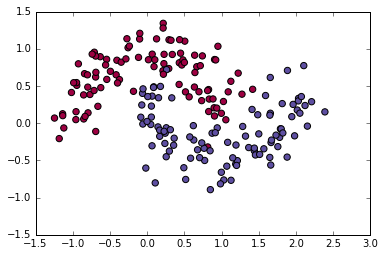

In [16]:
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_Y, cmap=plt.cm.Spectral)

In [43]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, cmap=plt.cm.Spectral)

SIZE DEFINITIONS

In [18]:
num_examples = len(train_X)
nn_input_dim = 2 # Input layer dimensionality
nn_output_dim = 2 #Output layer dimensionality
nn_hdim = 100 # Hidden layer dimensionality
#Grad descent params

epsilon = 0.01 #Learning rate
reg_lambda = 0.01 #Regularization paramter

In [19]:
W1 = theano.shared(np.random.randn(nn_input_dim, nn_hdim), name = 'W1')
b1 = theano.shared(np.zeros(nn_hdim), name = 'b1')
W2 = theano.shared(np.random.randn(nn_hdim, nn_output_dim), name = 'W2')
b2 = theano.shared(np.zeros(nn_output_dim), name = 'b2')

Now that we have randomly defined the parameters, let's create our forward propagation model, loss function, and 
prediciton. Theano has a wonderful feature where we can implement these as functions directly. Functions that can be called later in the code with input and output parameters. we use 'theano.function([input], [output])' for this.

In [35]:
#Forward propagation

z1 = X.dot(W1) + b1
a1 = T.tanh(z1)

z2 = a1.dot(W2) + b2
y_hat = T.nnet.softmax(z2) # Our predicted output of probabilities of different classes.

In [36]:
# Regularization
loss_reg = 1./num_examples * reg_lambda/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2)))
# Loss function (Using cross-entropy)

loss = T.nnet.categorical_crossentropy(y_hat, y).mean() + loss_reg

#Prediction (Outputs class with highest probability density)

prediction = T.argmax(y_hat, axis = 1)

NOTE: In the above cell, we haven't actually evaluated anything. We've just defined these terms. We will do the heavy
lifting shortly

In [37]:
# Let's define a few functions

forward_prop = theano.function([X], y_hat)
calc_loss =  theano.function([X, y], loss)
predict = theano.function([X], prediction)

 Now, what's left is to calculate our gradients. Recall, that in our implementation from scratch, we had to manually calculate the derivatives [by calculating regularized loss and then using backpropagation] which minimize our cost function. Well, Theano does all that heavy lifting for us!

In [38]:
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1, disconnected_inputs = 'ignore')

Now let's update our parameters

In [39]:
grad_step = theano.function([X, y], 
                           updates = ((W2, W2 - epsilon * dW2),
                                     (W1, W1 - epsilon * dW1),
                                     (b2, b2 - epsilon * db2),
                                     (b1, b1 - epsilon * db1)))

Now let's build our model to train our parameters!

In [40]:
def build_model(num_passes = 20000, print_loss = False):
    #Reinitialize parameters to random values again, in case we call this function multiple times
    np.random.seed(0)
    W1.set_value(np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim))
    b1.set_value(np.zeros(nn_hdim))
    W2.set_value(np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim))
    b2.set_value(np.zeros(nn_output_dim))
    
    #Perform gradient descent (BGD)
    
    for i in xrange(0, num_passes):
        grad_step(train_X, train_Y)
    
    #Print cost for every 1000 iterations
    
        if print_loss and i%1000 == 0:
            print "Loss after %i iterations: %f" %(i, calc_loss(train_X, train_Y))
            
    

In [41]:
build_model(print_loss = True)

Loss after 0 iterations: 0.681221
Loss after 1000 iterations: 0.290958
Loss after 2000 iterations: 0.275118
Loss after 3000 iterations: 0.255913
Loss after 4000 iterations: 0.233369
Loss after 5000 iterations: 0.210462
Loss after 6000 iterations: 0.189358
Loss after 7000 iterations: 0.170802
Loss after 8000 iterations: 0.154927
Loss after 9000 iterations: 0.141611
Loss after 10000 iterations: 0.130575
Loss after 11000 iterations: 0.121475
Loss after 12000 iterations: 0.113963
Loss after 13000 iterations: 0.107730
Loss after 14000 iterations: 0.102523
Loss after 15000 iterations: 0.098135
Loss after 16000 iterations: 0.094408
Loss after 17000 iterations: 0.091214
Loss after 18000 iterations: 0.088457
Loss after 19000 iterations: 0.086059


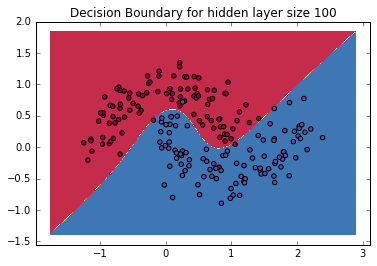

In [44]:
plot_decision_boundary(lambda x: predict(x))
plt.title("Decision Boundary for hidden layer size 100")